In [1]:
import sys, os, time, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
home_path = os.path.abspath(os.getcwd()+"/..")
sys.path.append(home_path)
sys.path.append(os.getcwd()+"/.."+"/.."+"/.."+"/JamesAHardwick")
from functions import *
from plotting_functions import *
from GF_functions import *
from PM_functions import *
from AHC_functions import *

In [2]:
def focus_phasemap_builder(AMM_points, focal_point_position, k, focal_point_phase = 0):

    """
    Builds a phasemap for an AMM or PAT creating a focus at some point in 3D space.

    args:
        AMM_points: matrix describing the postitions of elements on the AMM or PAT surface.
        focal_point_position: (x, y, z) coords of the focus.
        k: wavenumber
        
    returns:
        norm_phase_array: matrix of phase delays from -pi to pi, with the same size as AMM_points, describing the
        phase delays to build a focus at focal_point_position.

    """

    # matrix of distances from centre of each elem to focus
    travel_distance_array = np.sqrt((AMM_points[0] + focal_point_position[0])**2 + \
                                    (AMM_points[1] + focal_point_position[1])**2 + \
                                    (AMM_points[2] + focal_point_position[2])**2)

    # total change in phase of waves as they travel this distance.
    total_phase_array = focal_point_phase - travel_distance_array * k 

    # normalise between 0 and 2π [rads].
    norm_phase_array = np.remainder(total_phase_array, 2*np.pi) - np.pi

    return norm_phase_array

In [3]:
# ---> physics params <---
c0 = 343.  # [m/s]
v = 40000  # [Hz]
lam = c0 / v  # [m]
k = 2 * np.pi / lam  # [rads/m]
resolution = 4

In [4]:
# ----> AMM plane <----
m_AMM, n_AMM = 32, 32
dx_AMM = lam/2 # cell spacing [m]
AMM_centrepoint = (0, 0, 0)
AMM_sidelengths = [((m_AMM/2)*dx_AMM, (m_AMM/2)*dx_AMM),
                   ((n_AMM/2)*dx_AMM, (n_AMM/2)*dx_AMM),
                   (0, 0)]
AMM_points = points_vector_builder(AMM_centrepoint, AMM_sidelengths, dx_AMM)

# ----> normals & areas <----
normals = [np.zeros((1, n_AMM*m_AMM)), np.zeros((1, n_AMM*m_AMM)), np.ones((1, n_AMM*m_AMM))]
areas = (dx_AMM**2)*np.ones((1, n_AMM*m_AMM))

In [7]:
# ----> xy eval planes <----
focus_coords = [0, 0, 10*lam]
m_xy_eval, n_xy_eval = m_AMM*resolution, n_AMM*resolution
dx_xy_eval = dx_AMM/resolution
xy_eval_sidelengths = [(8*lam, 8*lam), (8*lam, 8*lam), (0, 0)] # [(-x, +x), (-y, +y), (-z, +z)]

xy_eval_points = points_vector_builder(focus_coords, xy_eval_sidelengths, dx_xy_eval)

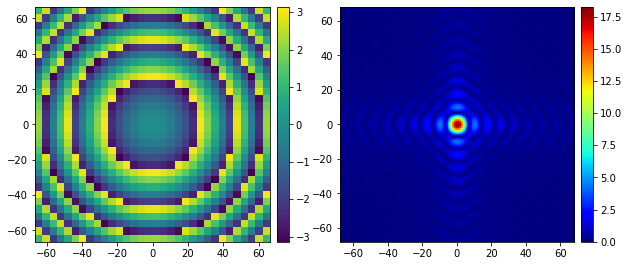

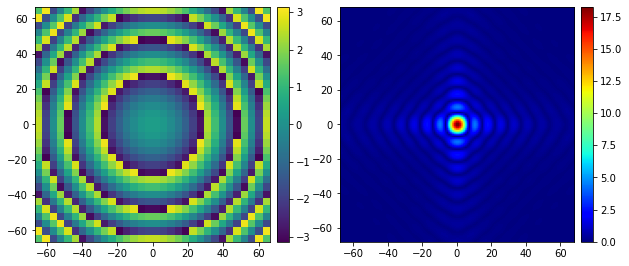

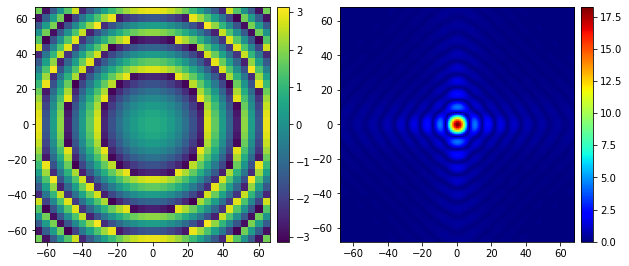

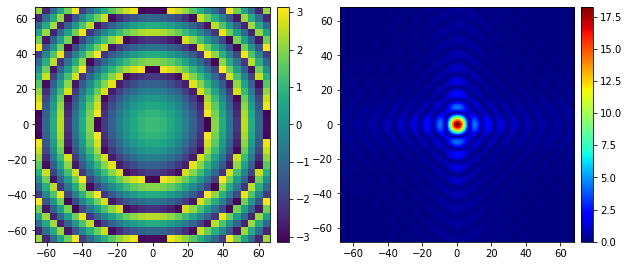

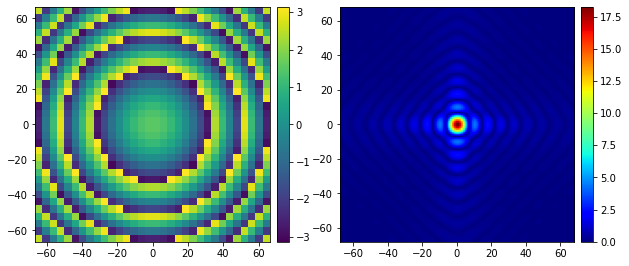

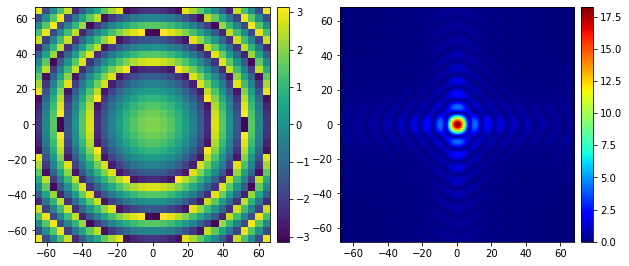

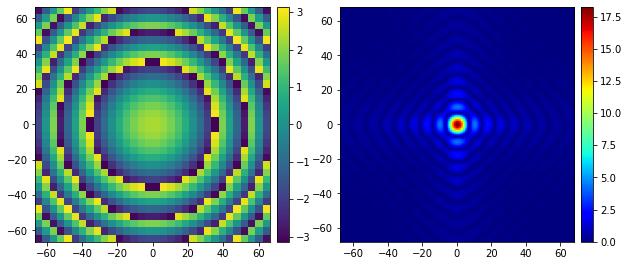

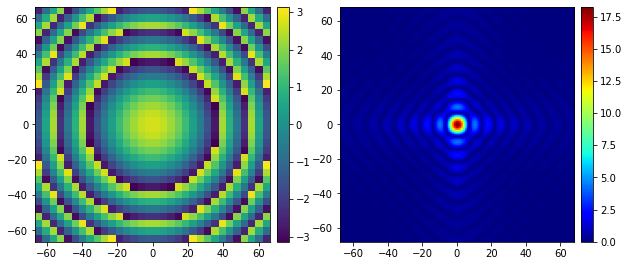

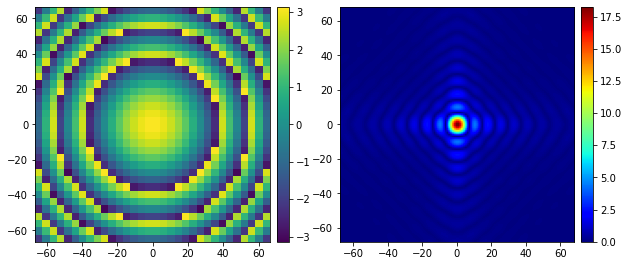

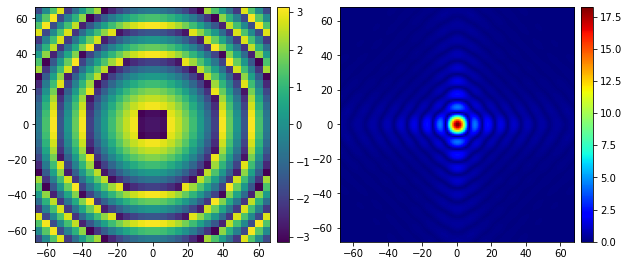

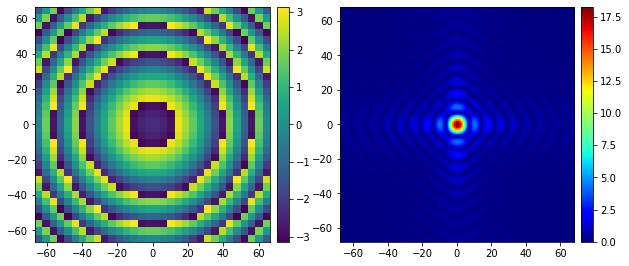

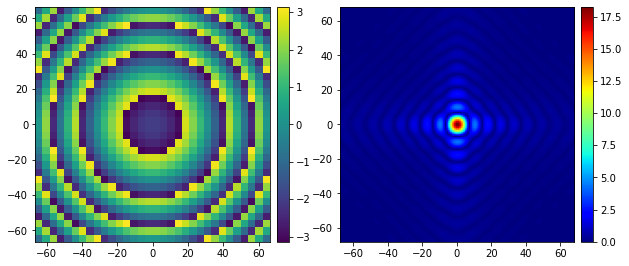

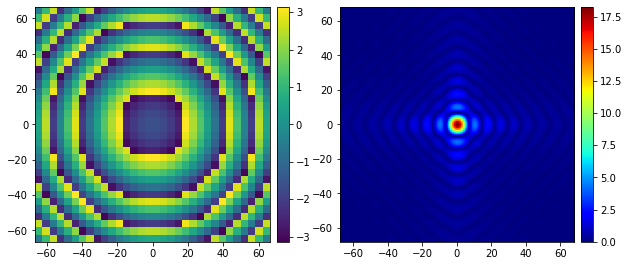

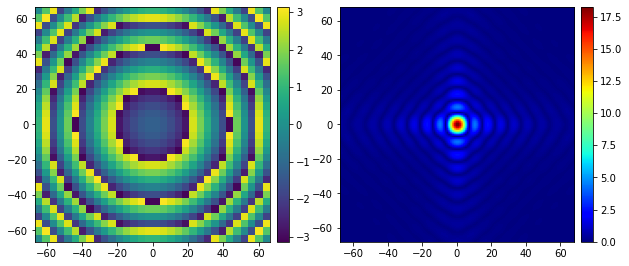

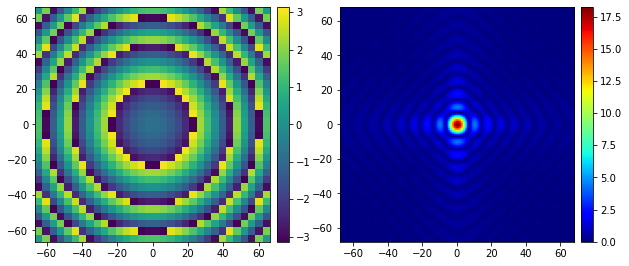

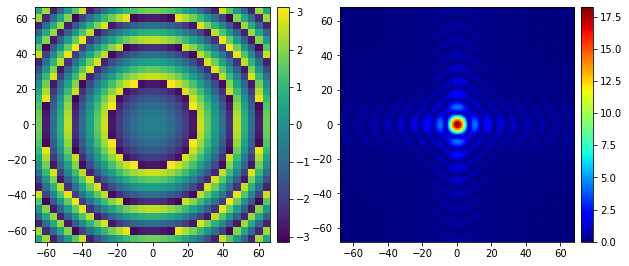

In [8]:
for focal_point_phase in np.arange(-np.pi, np.pi, np.pi/8):

    phasemap_vec = focus_phasemap_builder(AMM_points, focus_coords, k, focal_point_phase)
    surface_pressure = np.ones_like(phasemap_vec)*np.exp(1j*phasemap_vec)

    xy_H = GF_propagator_function_builder(AMM_points, xy_eval_points, normals, areas, k)
    xy_propagation = GF_prop(surface_pressure, xy_H, "forward").reshape(pf_shape(xy_eval_sidelengths, resolution, lam))

    fig, ax = basic_plotter(nrows=1, ncols=2,
                            figsize = (10, 10),
                            plottable_list = [phasemap_vec.reshape(m_AMM, n_AMM),
                                             abs(xy_propagation).reshape(pf_shape(xy_eval_sidelengths, resolution, lam))],
                            cmap_list = [plt.get_cmap("viridis"), plt.get_cmap("jet")],
                            vmax_list = [np.pi, np.amax(abs(xy_propagation))],
                            vmin_list = [-np.pi, 0],
                            points_list = [AMM_points, xy_eval_points])

    plt.show()